Some plots and sanity checks of simulated data

In [1]:
import pandas as pd
import numpy as np
import math 
import random
from tqdm import tqdm 
import os
import sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Get the current working directory
current_dir = os.getcwd()
# Go up one level to reach the root directory (ML4Processes)
root_dir = os.path.abspath(os.path.join(current_dir, ".."))
# Add the root directory to the Python path
if root_dir not in sys.path:
    sys.path.append(root_dir)

from utils.helper import read_json, write_json, transform_to_timestamp

In [111]:
fn = 'HelpDesk'

In [112]:
train_cvs = read_json(os.path.join(root_dir, f"event_log_simulations\\kde_prob\\{fn}\\train.json"))
train_cvs_df = pd.DataFrame(train_cvs, columns = ['timestamp'])
train_cvs_df.timestamp = pd.to_datetime(train_cvs_df.timestamp, format = '%d.%m.%Y %H:%M:%S')
train_cvs_df['date'] = pd.to_datetime(train_cvs_df.timestamp.dt.date)

test_cvs = read_json(os.path.join(root_dir, f"event_log_simulations\\kde_prob\\{fn}\\test.json"))
test_cvs_df = pd.DataFrame(test_cvs, columns = ['timestamp'])
test_cvs_df.timestamp = pd.to_datetime(test_cvs_df.timestamp, format = '%d.%m.%Y %H:%M:%S')
test_cvs_df['date'] = pd.to_datetime(test_cvs_df.timestamp.dt.date)

full_cvs_df = pd.concat([train_cvs_df, test_cvs_df], axis = 0, ignore_index=True)
full_cvs_df.set_index('date', inplace = True)

kde_csv = read_json(os.path.join(root_dir, f"event_log_simulations\\kde_prob\\{fn}\\simulated_run_1.json"))
kde_csv_df = pd.DataFrame(kde_csv, columns = ['timestamp'])
kde_csv_df.timestamp = pd.to_datetime(kde_csv_df.timestamp, format = '%d.%m.%Y %H:%M:%S')
kde_csv_df['date'] = pd.to_datetime(kde_csv_df.timestamp.dt.date)
kde_csv_df.set_index('date', inplace=True)

File correctly read: c:\Users\User\OneDrive - uni-mannheim.de\Desktop\Work\Temporal_ML\Papers\AT-KDE\event_log_simulations\kde_prob\HelpDesk\train.json.
File correctly read: c:\Users\User\OneDrive - uni-mannheim.de\Desktop\Work\Temporal_ML\Papers\AT-KDE\event_log_simulations\kde_prob\HelpDesk\test.json.
File correctly read: c:\Users\User\OneDrive - uni-mannheim.de\Desktop\Work\Temporal_ML\Papers\AT-KDE\event_log_simulations\kde_prob\HelpDesk\simulated_run_1.json.


In [113]:
#test domain 
start_date = kde_csv_df.index[0]
end_date = kde_csv_df.index[-1]

In [114]:
def make_weekday_time_heatmap(
    df,
    timestamp_col="timestamp",
    bin_hours=3,
    vmin_value=0,
    vmax_value=None,
    clip=False,
    title="Activity by Weekday and Time Bin"
):
    """
    Heatmap with weekdays on x-axis (1..7) and n-hour bins on y-axis.
    Colors scale from vmin_value to vmax_value (white reserved for zero counts).

    Parameters
    ----------
    df : pd.DataFrame
        Contains a datetime column `timestamp_col`.
    timestamp_col : str
        Name of the column with pandas datetime values.
    bin_hours : int
        Size of the time bins in hours (>0).
    vmin_value : int or float
        Lower bound for the colormap (e.g., 0).
    vmax_value : int or float or None
        Upper bound for the colormap (e.g., 100). If None, uses data max (excluding zeros).
    clip : bool
        If True, values are clipped to [vmin_value, vmax_value] for color scaling.
    title : str
        Figure title.

    Returns
    -------
    fig, ax : matplotlib Figure and Axes
    counts : pd.DataFrame
        Counts table with rows = bin start hours, columns = weekdays (1..7).
    """
    if bin_hours <= 0:
        raise ValueError("bin_hours must be a positive integer.")

    ts = pd.to_datetime(df[timestamp_col], errors="coerce")
    df = df.loc[~ts.isna()].copy()
    df[timestamp_col] = ts = ts.loc[~ts.isna()]

    # Monday=0..Sunday=6 -> 1..7
    df["weekday"] = ts.dt.dayofweek + 1

    # Bin assignment
    minutes = ts.dt.hour * 60 + ts.dt.minute
    step_min = bin_hours * 60
    bin_start_hour = ((minutes // step_min) * bin_hours).astype(int)
    bin_start_hour = bin_start_hour.clip(0, 24 - bin_hours)
    df["bin_start_hour"] = bin_start_hour

    weekdays = np.arange(1, 8)                 # 1..7
    bins = np.arange(0, 24, bin_hours, int)    # 0, bin_hours, ...

    counts = (
        df.groupby(["bin_start_hour", "weekday"])
          .size()
          .unstack("weekday")
          .reindex(index=bins, columns=weekdays, fill_value=0)
    )

    data = counts.values
    # Mask zero counts to keep them pure white
    masked = np.ma.masked_where(data == 0, data)

    # Determine vmax default (exclude zeros, fallback to vmin if all zeros)
    if vmax_value is None:
        nonzero_max = data[data > 0].max() if (data > 0).any() else vmin_value or 1
        vmax_value = nonzero_max

    if vmin_value >= vmax_value:
        raise ValueError("vmin_value must be strictly less than vmax_value.")

    # Optional clipping for display normalization
    if clip:
        masked = np.ma.masked_where(data == 0, np.clip(data, vmin_value, vmax_value))

    cmap = plt.cm.Reds.copy()
    cmap.set_bad(color="white")  # masked (zeros) -> white

    fig, ax = plt.subplots(figsize=(8, 5), dpi=140)
    im = ax.imshow(
        masked,
        aspect="auto",
        origin="lower",
        cmap=cmap,
        vmin=vmin_value,
        vmax=vmax_value
    )

    # Per-cell gridlines
    nrows, ncols = counts.shape
    ax.set_xticks(np.arange(-0.5, ncols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, nrows, 1), minor=True)
    ax.grid(which="minor", color="#808080", linestyle="-", linewidth=0.9)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.grid(False, which="major")

    # Axis ticks & labels
    ax.set_xticks(np.arange(ncols))
    ax.set_xticklabels(weekdays)

    def fmt_bin(h):
        end = min(h + bin_hours, 24)
        return f"{h:02d}–{end:02d}"

    ax.set_yticks(np.arange(nrows))
    ax.set_yticklabels([fmt_bin(h) for h in bins])

    ax.set_xlabel("Weekday (Mon=1 … Sun=7)")
    ax.set_ylabel(f"{bin_hours}-hour bin")
    ax.set_title(title)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Count of timestamps")

    plt.tight_layout()
    return fig, ax, counts

In [115]:
full_cvs_df.loc[start_date:end_date].groupby('date').agg('count').max()[0]

20

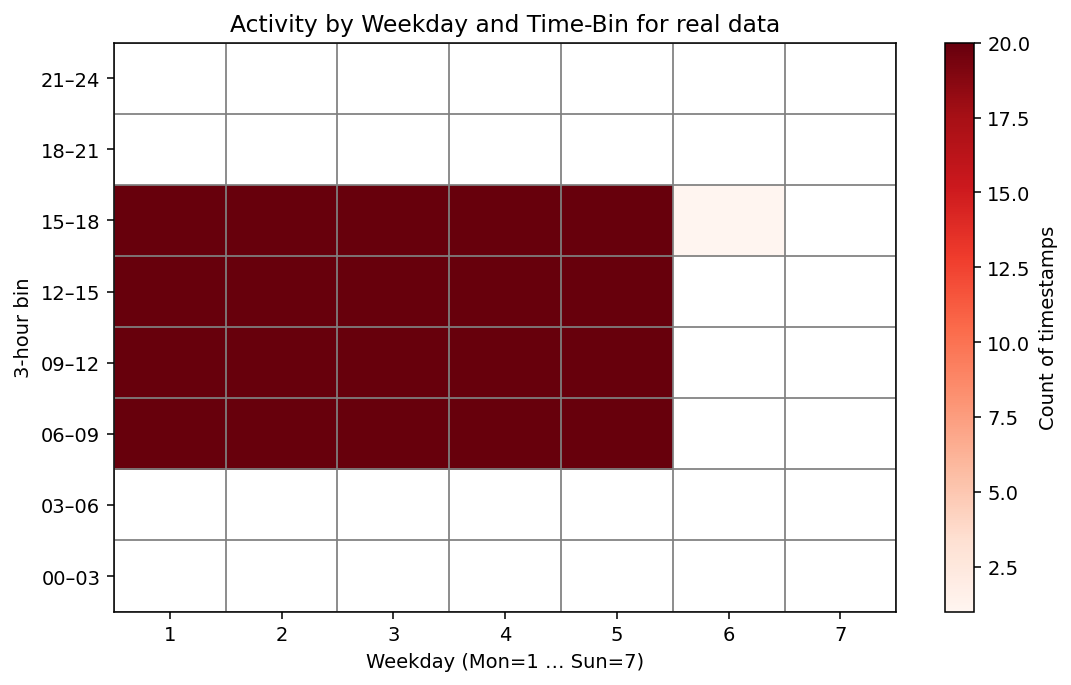

In [116]:
fig, ax, counts = make_weekday_time_heatmap(full_cvs_df.loc[start_date:end_date], 
                                            "timestamp", 
                                            bin_hours=3, 
                                            vmin_value=full_cvs_df.loc[start_date:end_date].groupby('date').agg('count').min()[0], 
                                            vmax_value=full_cvs_df.loc[start_date:end_date].groupby('date').agg('count').max()[0], 
                                            title='Activity by Weekday and Time-Bin for real data')
plt.show()

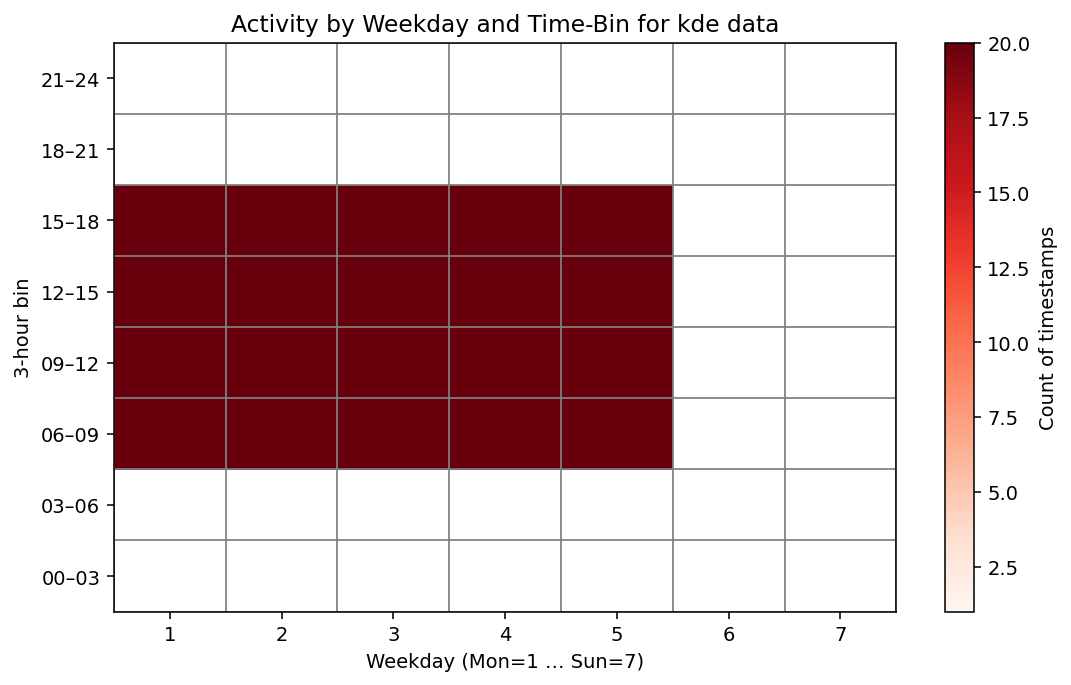

In [117]:
fig, ax, counts = make_weekday_time_heatmap(kde_csv_df, 
                                            "timestamp", 
                                            bin_hours=3, 
                                            vmin_value=full_cvs_df.loc[start_date:end_date].groupby('date').agg('count').min()[0], 
                                            vmax_value=full_cvs_df.loc[start_date:end_date].groupby('date').agg('count').max()[0], 
                                            title='Activity by Weekday and Time-Bin for kde data')
plt.show()

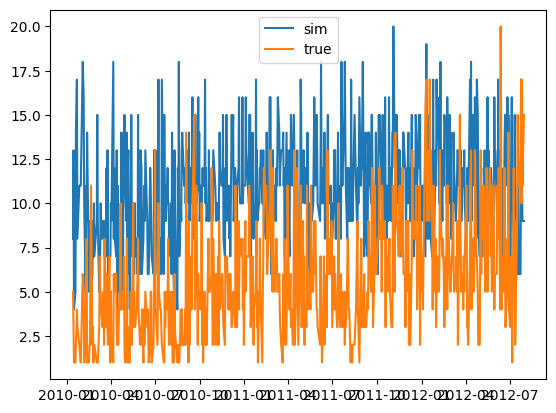

In [118]:
plt.plot(kde_csv_df.groupby('date').agg('count'), label = 'sim')
plt.plot(full_cvs_df.loc[start_date:end_date].groupby('date').agg('count'), label = 'true')
plt.legend()
plt.show()